In [ ]:
'''
Alejandro Fernández Trigo
'''

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Cargar la imagen del enunciado Filomena:
filomena = cv.imread('img/Filomena.jpg', cv.IMREAD_GRAYSCALE)

In [4]:
'''
NOS VOLVEMOS A TRAER EL ISODATA DEL EJERCICIO I Y LA FUNCIÓN DE SEUDOCOLOR
DADA POR EL ENUNCIADO
'''

# Función isodata del ejercicio I:
def isodata(imagen, C):
    
    # Matriz de ceros dada por el enunicado:
    m = np.zeros((C, imagen.shape[2]))
    
    # Imagen "vacía" sobre la que trabajamos:
    resultado = np.ones((imagen.shape[0], imagen.shape[1]), dtype = int)
    
    # Centros ""aleatorios"" para las clases (dado por el enunciado)
    # Los valores son los índices RGB pero vienen prefijados!
    m[0,:] = (30., 60., 30.)
    m[1,:] = (60., 70., 30.)
    m[2,:] = (20., 40., 20.)
    m[3,:] = (100., 150., 40.)
    
    # Aquí comienza la clasificación: 
    # LE HE PUESTO UN LÍMITE DE ITERACIONES POR SI ACASO
    limite = 0
    clasificado = False
    lista_resultados = []
    while (limite < 10):

        print("Iteración nº " + str(limite))

        # Calcula la distancia y llama a la funcion que asigna los ND a los clusters:
        distancias = distancia_euclidea(imagen, m)
        print("Distancias calculadas: " + str(distancias))
        resultado = clasifica(resultado, distancias)
        # Si la clasificación no cambia, seguimos iterando:
        if len(lista_resultados) != 0:
            clasificado = compara(resultado, lista_resultados[0])
            if clasificado == True:
                return resultado
            else:
                lista_resultados.pop()

        # Me quedo con la clasificación como un diccionario:
        clasificacion = agrupa(imagen, resultado, C)
        print("Clasificación: " + str(clasificacion))
        
        # ¡ACTUALIZO LOS CENTROS!
        print("Centro actual: " + str(m))
        m = recalcula(clasificacion, imagen, resultado, C)
        print("Nuevo centro: " + str(m))

        limite = limite + 1
        lista_resultados.append(resultado)

    # Devolver la imagen
    return resultado

# Función que dadas las distancias asigna cada ND a un cluster:
def clasifica(resultado, distancias):

    for i in range(resultado.shape[0]):
        for j in range(resultado.shape[1]):
                
            lista_distancia = distancias[(i,j)]
            minima_distancia = min(lista_distancia)
            # Actualiza resultado con el valor del cluster al que queda asignado:
            resultado[i][j] = lista_distancia.index(minima_distancia)
            
    return resultado

# Función que extrae los ND una vez asignados:
def agrupa(imagen, resultado, C):
        
    clasificacion = {}
    for cluster in range(C):
        valores = []
        for i in range(resultado.shape[0]):
            for j in range(resultado.shape[1]):
                if resultado[i][j] == cluster:
                    valores.append(imagen[i][j])
                    clasificacion[cluster] = valores

    return clasificacion

# Función que compara un resultado guardado con otro nuevo:
def compara(antiguo, nuevo):

    diferencia = False
    for i in range(antiguo.shape[0]):
        for j in range(antiguo.shape[1]):
            if antiguo[i][j] != nuevo[i][j]:
                diferencia = True

    return diferencia

# Función que recalcula los centros:
def recalcula(clasificacion, imagen, resultado, C):

    # Calcular el valor medio de todos los puntos (centro incluido) pero
    # POR CLASE, esto es, tomar los píxeles de la clase X y calculo la media de 
    # estos entre el total de esa clase => ESTO ES EL NUEVO CENTRO
    medias = calcula_media(clasificacion)
    print("Medias calculadas: " + str(medias))

    '''
    Como me estoy comiendo chorrocientos mil trillones de errores por culpa de la clasificación que hace,
    no recalculo en base a la constante C, sino que voy a observar cuantos valores diferentes (clusters
    reales) ha localizado en la imagen original, de lo contrario me como errores de índices; de esa forma
    queda un código que funciona. 
    '''
    lista = []
    for i in range(resultado.shape[0]):
        for j in range(resultado.shape[1]):
            lista.append(resultado[i][j])
    
    n_clusters = np.unique(lista)

    # Con las medias actualiza los centros que son ternas de valores RGB: la media ya está calculada
    nuevo_centro = np.zeros((C, imagen.shape[2]))

    for c in n_clusters:
        nuevo_centro[c,:] = medias[c]

    return nuevo_centro

# Función que calcule la media:
def calcula_media(clasificacion):

    medias = {}
    valores = []
    for cluster in clasificacion:
        valores = clasificacion[cluster]
        medias[cluster] = sum(valores) / len(valores)
    
    return medias
    
# Función que calcula la distancia euclídea en tres dimensiones porque se trata de RGB:
def distancia_euclidea(imagen, matriz_centros):
    
    # Los centros actuales vienen dados por la matriz m del enunciado (prefijados)
    # Monto un diccionario para almacenar la distancia a cada centro de cada ND como una lista:
    distancias = {}
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            distancias[(i,j)] = list()
    
    # Calcular las distancias eucledianas entre los ND y los centros (fijados):
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            lista = []
            for centro in matriz_centros:
                # Distancia de ese ND al centro:
                lista.append(calculo_distancia(i, j, imagen, centro))
            distancias[(i,j)] = lista
            
    return distancias

# Función que hace el cálculo euclídeo por separado:
def calculo_distancia(i,j, imagen, centro):
    # Raiz cuadrada de la suma de los cuadrados de las diferencias entre el punto de la imagen y el centro:
    # OJO que centro también es una matriz
    return np.sqrt( ((imagen[i][j][0] - centro[0])**2) + ((imagen[i][j][1] - centro[1])**2) + ((imagen[i][j][2] - centro[2])**2) )

# Función seudo del enunciado:    
def seudo(imagen):
    
    resultado = np.zeros((imagen.shape[0], imagen.shape[1], 3), np.uint8)
    
    i = 0
    while i < imagen.shape[0]:
        j = 0
        while j < imagen.shape[1]:
            if imagen[i,j] == 0:
                resultado[i,j,:] = [255,0,0]
            elif imagen[i,j] == 1:
                resultado[i,j,:] = [0,255,0]
            elif imagen[i,j] == 2:
                resultado[i,j,:] = [0,0,255]
            elif imagen[i,j] == 3:
                resultado[i,j,:] = [255,255,0]                
            elif imagen[i,j] == 4:
                resultado[i,j,:] = [0,255,255]
            elif imagen[i,j] == 5:
                resultado[i,j,:] = [255,0,255]
            else:
                resultado[i,j,:] = [0,0,0]
            j = j + 1
        i = i + 1
    return resultado 

In [3]:
'''
ADEMÁS, NOS TRAEMOS LA FUNCIÓN DIEZMADO DEL EJERCICIO 1 DE LA PRÁCTICA 4
'''

# Función diezmado: imagen + factor de entrada.
def diezmado(img, R):
     
    valores_digitales = []
    
    # Leer cada pixel pero nos quedamos solo con ciertos
    # valores digitales en base a (1/R)
    i = 0
    while i < img.shape[0]:
        j = 0
        while j < img.shape[1]:
            valores_digitales.append(img[i,j])
            j += int(1/R)
        i += int(1/R)
    
    # 'reshape' transforma esa lista en imagen:
    return np.reshape(valores_digitales,
                        [int(np.ceil(img.shape[0] / (int(1/R)))),
                        int(np.ceil(img.shape[1] / (int(1/R))))])

True

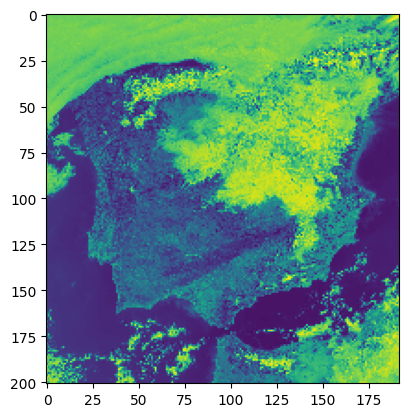

In [5]:
# Aplicamos el diezmado a la imagen original
imagen_diezmada = diezmado(filomena, 0.1)
plt.imshow(imagen_diezmada)
cv.imwrite("salida/4_Diezmado.png", imagen_diezmada)

In [6]:
# Aplicamos isodata con el parámetro dado C=4
imagen_clasificada = isodata(imagen_diezmada, 4)
plt.imshow(imagen_clasificada)
cv.imwrite("salida/4_Diezmado_y_Clasificado.png", imagen_clasificada)

IndexError: tuple index out of range

In [ ]:
# Aplicamos seudocolor a la clasificación:
imagen_coloreada = seudo(imagen_clasificada)
plt.imshow(imagen_coloreada)
cv.imwrite("salida/4_Diezmado_Clasificado_y_Coloreado.png", imagen_coloreada)